# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import os

from scripts import utils, alerceanomalies, run_experiments
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.svm import OneClassSVM
import distclassipy as dcpy
from distclassipy.anomaly import DistanceAnomaly
import pickle

from sklearn.base import BaseEstimator, OutlierMixin
epsilon = np.finfo(np.float32).eps


with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

from IPython.core.display import HTML
from IPython.display import display

import squarify
set3colors = [matplotlib.colors.rgb2hex(x) for x in plt.cm.Set3.colors]
knowncolors = set3colors[:4]
unknowncolors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
unknowncolors = set3colors[4:]+unknowncolors

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# 1. Define models to test

In [2]:
models_to_test = {
    "iForest": IsolationForest( #using alerce anomaly params
        n_estimators=100,
        max_samples=256,
        contamination=0.001,
        random_state=seed_val
    ),
    "LOF": LocalOutlierFactor(
        n_neighbors=20, 
        novelty=True,  # IMPORTANT: Allows use on new data
        contamination='auto'
    ),
    
    "OC-SVM": OneClassSVM(
        kernel='rbf',
        nu=0.001
    ),

    "Autoencoder": alerceanomalies.AutoencoderAnomalyDetector(
        encoding_dim=32, # Can be tuned
        epochs=500,
        patience=15,
    ),

    "MCSVDD": alerceanomalies.ClassSVDDAnomalyDetector(
        z_dim=64,
        epochs=500,
        patience=15,
        lr=1e-4,
        verbose=False
    ),
        
    "DiMMAD (med-med)": DistanceAnomaly(
        cluster_agg='median',
        metric_agg='median',
        normalize_scores=True
    ),

    "DiMMAD (min-med)": DistanceAnomaly(
        cluster_agg='min',
        metric_agg='median',
        normalize_scores=True
    ),

}

# 2. Load the data

In [3]:
elasticc_features = pd.read_parquet("data/elasticc_features.parquet")

In [4]:
new_knowns = ['SNIcBL+HostXT_V19', 'SNIc-Templates', 'SNIa-SALT3', 'SNIb-Templates',
             'SNII+HostXT_V19', 'SNIa-91bg', 'SNIIb+HostXT_V19', 'SNIb+HostXT_V19', 
              'SNII-NMF', 'SNIIn+HostXT_V19', 'SNII-Templates','SNIc+HostXT_V19', 'SNIax', 
              'SNIIn-MOSFIT', 'SLSN-I+host', 'SLSN-I_no_host']

new_unknowns = [
    'PISN-STELLA_HYDROGENIC', 'PISN-MOSFIT','PISN-STELLA_HECORE',   
                ]

features_to_use = [
    'SPM_A_g', 'SPM_gamma_g', 'SPM_beta_g', 'SPM_tau_rise_g', 'SPM_tau_fall_g',
    'SPM_A_r', 'SPM_gamma_r', 'SPM_beta_r', 'SPM_tau_rise_r', 'SPM_tau_fall_r',
    'SPM_A_i', 'SPM_gamma_i', 'SPM_beta_i', 'SPM_tau_rise_i', 'SPM_tau_fall_i',
    'SPM_A_z', 'SPM_gamma_z', 'SPM_beta_z', 'SPM_tau_rise_z', 'SPM_tau_fall_z',
    'SPM_A_Y', 'SPM_gamma_Y', 'SPM_beta_Y', 'SPM_tau_rise_Y', 'SPM_tau_fall_Y',
]

elasticc_features=elasticc_features[elasticc_features["class"].isin(new_knowns+new_unknowns)]

# Could use features we know are better for the 4 variable star classification
# but don't want to bias. additionally, the above features are simple and general
# and have very little NaNs.
tot_frac_withoutnans = len(elasticc_features[elasticc_features["class"].isin(new_knowns+new_unknowns)].loc[:,features_to_use].dropna())/len(elasticc_features)
print(f"{tot_frac_withoutnans:.1%} of the dataset is clean and free of NaNs")

98.2% of the dataset is clean and free of NaNs


In [5]:
normal_frac_withoutnans = []
for col in elasticc_features.columns:
    if col=="class":
        continue
    normal_frac_withoutnans.append(len(elasticc_features[col].dropna())/len(elasticc_features))

normal_frac_withoutnans = np.median(normal_frac_withoutnans)

print(f"The median no. of objects across columns which are not NaNs is {normal_frac_withoutnans:.1%}")

The median no. of objects across columns which are not NaNs is 23.8%


In [6]:
all_classes = np.concatenate([new_knowns, new_unknowns])
full_df = elasticc_features[elasticc_features['class'].isin(all_classes)]
full_df = full_df.loc[:, list(features_to_use) + ["class"]].dropna(subset=features_to_use)
full_df = full_df[~full_df.index.duplicated(keep='first')]

# full_df['status'] = np.where(full_df['class'].isin(new_knowns), 'normal', 'anomalous')
# will use this for stratification

full_inlier_df = full_df[full_df["class"].isin(new_knowns)]
smallest_class_count = full_inlier_df["class"].value_counts().min()
full_outlier_df = full_df[full_df["class"].isin(new_unknowns)]

# 3. Run the tests

In [7]:
result_path = "results/elasticc_rid_results.pkl"

In [8]:
if not os.path.exists(result_path):
    all_run_results = run_experiments.run_experiment(
        N_RUNS = 20, 
        full_inlier_df=full_inlier_df, 
        models_to_test=models_to_test,
        full_outlier_df=full_outlier_df,
        new_knowns = new_knowns, 
        features_to_use = features_to_use,
        seed_val=seed_val
    )
    
    with open(result_path,"wb") as fp:
        pickle.dump(all_run_results, fp)

else:
    with open(result_path,"rb") as fp:
        all_run_results=pickle.load(fp)

# 4. Plot the tests

In [9]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.font_manager as font_manager
fpath = Path("font/cmunrm.ttf")
font_manager.fontManager.addfont(fpath)
prop = font_manager.FontProperties(fname=fpath)
font_name = prop.get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

In [10]:
newnames = {
 'score_DistClassiPy (min-median)': 'score_DiMMAD (min-med)',
 'score_DistClassiPy (median-median)': 'score_DiMMAD (med-med)',
 'score_IsolationForest': 'score_iForest',
 'score_LocalOutlierFactor': 'score_LOF',
 'score_OneClassSVM': 'score_OC-SVM',
 'score_Autoencoder': 'score_Autoencoder',
 'score_ClassSVDD': 'score_MCSVDD',
}

for i in range(len(all_run_results)):
    ar = all_run_results[i]
    all_run_results[i] = ar.rename(columns=newnames)

Budget 300


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

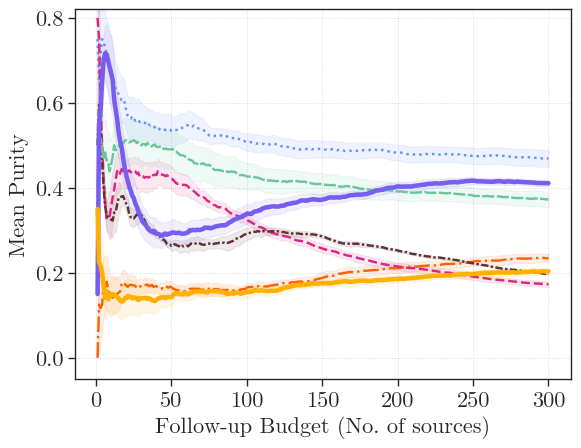

Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

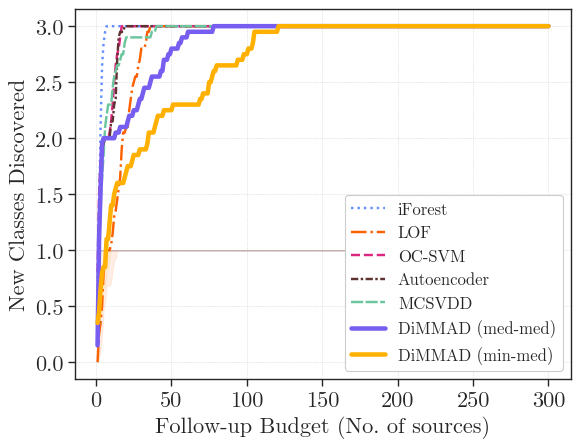

In [11]:
print("Budget 300")
fig = run_experiments.analysis_with_errors(models_to_test, all_run_results, budget=300, metric='purity')
plt.ylim(-0.05,0.82)
plt.gca().get_legend().remove()
plt.savefig("plots/Fig5a.pdf", bbox_inches="tight")
plt.show()

fig = run_experiments.analysis_with_errors(models_to_test, all_run_results, budget=300, metric='diversity')
plt.savefig("plots/Fig5b.pdf", bbox_inches="tight")
plt.show()

Budget 2000


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

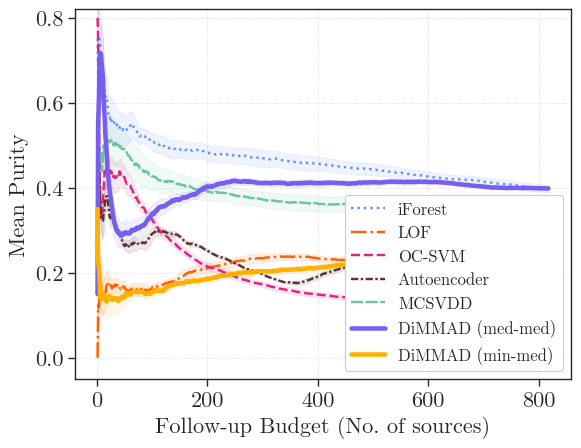

Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

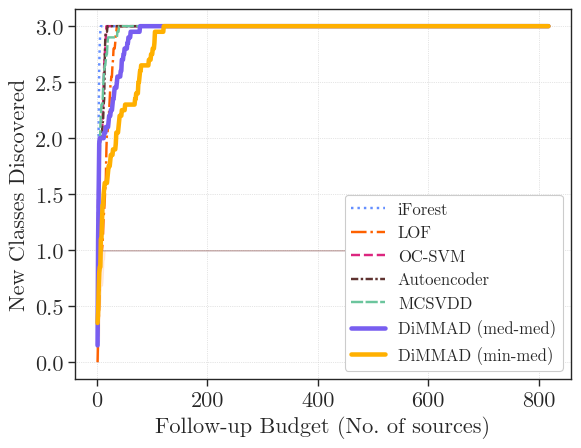

In [12]:
print("Budget 2000")
fig = run_experiments.analysis_with_errors(models_to_test, all_run_results, budget=2000, metric='purity')
plt.ylim(-0.05,0.82)
plt.show()

fig = run_experiments.analysis_with_errors(models_to_test, all_run_results, budget=2000, metric='diversity')
plt.show()

Budget 10,000


Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

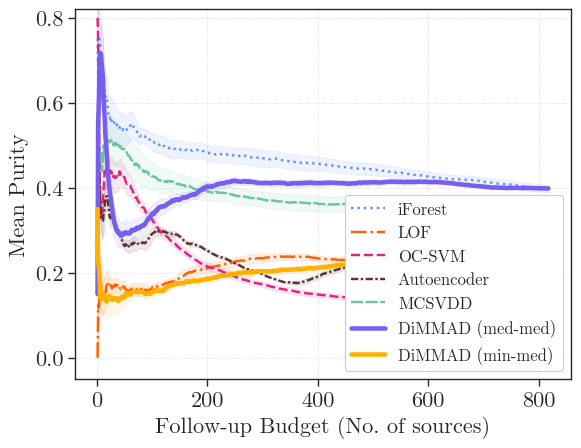

Analyzing Models:   0%|          | 0/7 [00:00<?, ?it/s]

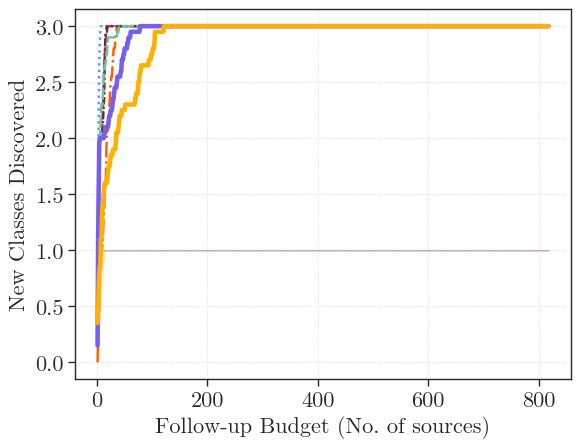

In [13]:
print("Budget 10,000")
fig = run_experiments.analysis_with_errors(models_to_test, all_run_results, budget=10000, metric='purity')
plt.ylim(-0.05,0.82)
plt.show()

fig = run_experiments.analysis_with_errors(models_to_test, all_run_results, budget=10000, metric='diversity')
plt.gca().get_legend().remove()
plt.show()